# Lab 7

Wyatt Saltzman and Landon Wood  
Dr. Larson  
CS 7324  
December 4, 2023

In [62]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
%matplotlib inline

print('Numpy version: ', np.__version__)
print('Tensorflow version: ', tf.__version__)

Numpy version:  1.24.3
Tensorflow version:  2.13.0


In [63]:
# Load the data

DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

df = pd.read_csv('Data/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


We only require sentiment and text so we will drop the other columns.

In [64]:
df = df[['sentiment', 'text']]

df['sentiment'] = df['sentiment'].replace(4, 1)

Now we reduce the tweets from 1.6 million to 50,000 so it doesn't take forever to train.

In [65]:
# reduce size of dataset to 50,000 with equal number of positive and negative tweets
df_pos = df[df['sentiment'] == 1].sample(25000)
df_neg = df[df['sentiment'] == 0].sample(25000)
df = pd.concat([df_pos, df_neg], axis=0).reset_index(drop=True)

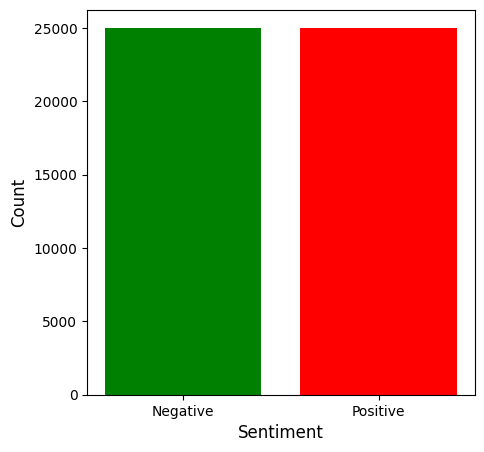

In [66]:
# plot the distribution of positive and negative sentiment

count = reduced_df['sentiment'].value_counts()
plt.figure(figsize=(5,5))
plt.bar(count.index, count.values, color=['red', 'green'])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.xticks(range(len(count.index)), ['Negative', 'Positive'])
plt.show()

### Preprocessing the Test

In [67]:
# convert text to lower case
# replace urls with token
# replace user handles with token
# replace emojis with token
# replace contractions with their expansions
# remove non-alphanumeric characters
import re
import contractions

def preprocessing(tweet):
    # Convert tweet to lower case
    tweet = tweet.lower()
    
    # Replace URLs with token
    tweet = re.sub(r'http\S+|www\S+|https\S+', 'URL', tweet)
    
    # Replace user handles with token
    tweet = re.sub(r'@\w+', 'USER', tweet)

    emoji_replacements = {
        '❤️': 'HEART_EMOJI',
        '😂': 'LAUGHING_FACE_EMOJI',
        '😊': 'SMILING_FACE_EMOJI',
        '😎': 'COOL_FACE_EMOJI',
        '👍': 'THUMBS_UP_EMOJI',
        '😭': 'CRYING_EMOJI'
    }
    # Replace emojis with token (basic example)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    tweet = emoji_pattern.sub('EMOJI', tweet)
    
    # Replace contractions with their expansions
    tweet = contractions.fix(tweet)
    
    # Remove non-alphanumeric characters
    tweet = re.sub(r'[^a-zA-Z0-9\s]', '', tweet)
    
    return tweet


In [68]:
%%time
df['processed_text'] = df['text'].apply(preprocessing)

CPU times: user 829 ms, sys: 8.22 ms, total: 838 ms
Wall time: 386 ms


In [69]:
# print out 10 samples of the original and processed text

for i in range(30,40):
    print('Original text: ', df['text'][i])
    print('Processed text: ', df['processed_text'][i])
    print()


Original text:  Goin to the place where we had our first date 
Processed text:  goin to the place where we had our first date 

Original text:  won't stop till i get a reply, sorry 
Processed text:  will not stop till i get a reply sorry 

Original text:  is bored 2 the X-treemmee i have dancing 2morrow..yayy 
Processed text:  is bored 2 the xtreemmee i have dancing 2morrowyayy 

Original text:  @zamare ENJOY ur long weekend! I know I will! 
Processed text:  USER enjoy you are long weekend i know i will 

Original text:  puttin on PJ's wow, comfy 
Processed text:  puttin on pjs wow comfy 

Original text:  Going to bed early again. Got mucho homework and beauty stuff to do tomorow such as my hair color  night twits 
Processed text:  going to bed early again got mucho homework and beauty stuff to do tomorow such as my hair color  night twits 

Original text:  mmm i wanna go in the poooool 
Processed text:  mmm i want to go in the poooool 

Original text:  @Pappegena yeh, i like films,rea

In [95]:
data_pos = df[df['sentiment'] == 1]['processed_text'].values
data_neg = df[df['sentiment'] == 0]['processed_text'].values

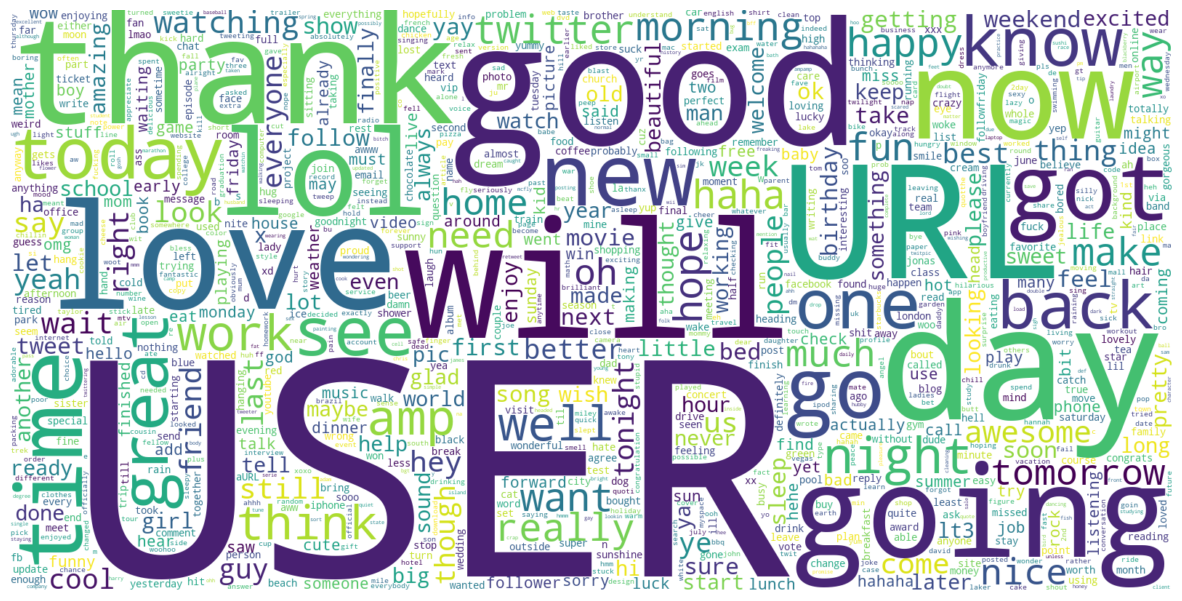

In [71]:
# create a word cloud for positive and negative tweets
from wordcloud import WordCloud

def plot_wordcloud(data, color='black'):
    wordcloud = WordCloud(background_color=color, max_words=1000, width=1600, height=800, random_state=42, collocations=False).generate(" ".join(data))
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

plot_wordcloud(data_pos, 'white')

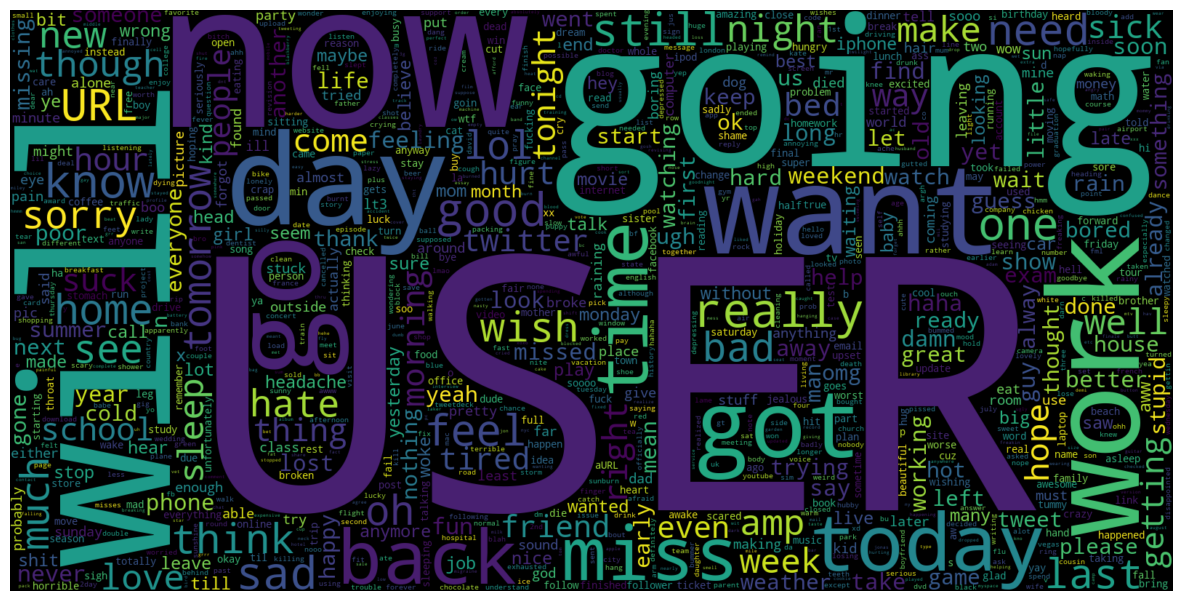

In [72]:
plot_wordcloud(data_neg)

In [73]:
# find the max length of a tweet

max_len = max([len(s.split()) for s in df['processed_text']])
print('Max length of a tweet: ', max_len)

Max length of a tweet:  35


/var/folders/85/z2b31c3n0q32jnj1q6mdyghr0000gn/T/ipykernel_30192/247229623.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot([len(s.split()) for s in df['processed_text']], color='green')


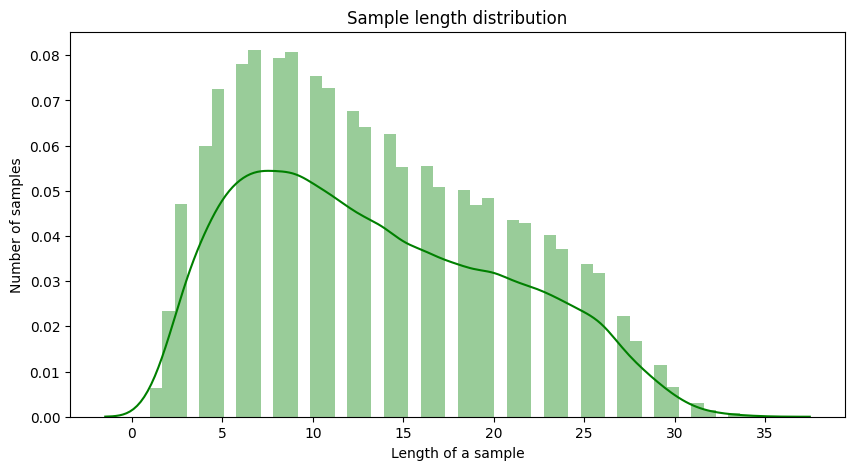

In [100]:
# plot the distribution of tweet lengths

plt.figure(figsize=(10, 5))
sns.distplot([len(s.split()) for s in df['processed_text']], color='green')
plt.xlabel('Length of a sample')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()

In [81]:
%%time
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = df['processed_text'].values
y = df['sentiment'].values

MAX_LEN = 35 # as this was the max length of a tweet back in the day
VOCAB_SIZE = 60000

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>', lower=False)
tokenizer.fit_on_texts(X)

sequences = tokenizer.texts_to_sequences(X)

word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index) if VOCAB_SIZE > len(word_index) else VOCAB_SIZE
top_words = min((len(word_index), VOCAB_SIZE))
print('Found %s unique tokens. Distilled to %s.' % (len(word_index), top_words))

X = pad_sequences(sequences, maxlen=MAX_LEN)
y_ohe = keras.utils.to_categorical(y, 2)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)

Found 42490 unique tokens. Distilled to 42490.
Shape of data tensor: (50000, 35)
Shape of label tensor: (50000, 2)
CPU times: user 719 ms, sys: 33 ms, total: 752 ms
Wall time: 754 ms


### Splitting the Data

X_train shape:  (40000, 35) Label shape:  (40000, 2)


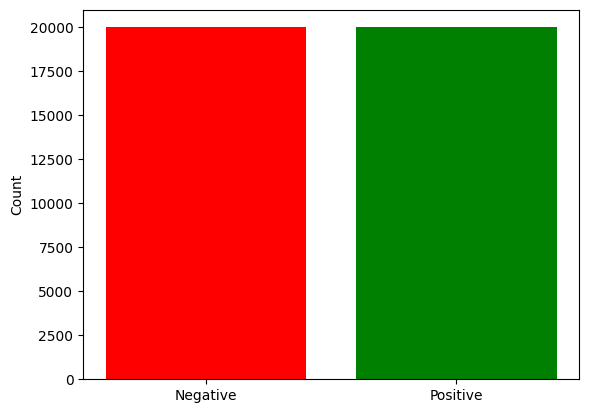

In [82]:
from sklearn.model_selection import train_test_split

# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_ohe,test_size=0.2, random_state=42, stratify=y_ohe)

# print out some stats of the data
print('X_train shape: ', X_train.shape, 'Label shape: ', y_train.shape)
count = np.sum(y_train, axis=0)
plt.bar(range(2), count, color=['red', 'green'])
plt.xticks(range(2), ['Negative', 'Positive'])
plt.ylabel('Count')
plt.show()

### Embedding

We decided to use glove's twitter embeddings because we are using a Twitter dataset.

In [96]:
%%time
EMBEDDING_SIZE = 100

embeddings_index = {}
f = open('Embeddings/glove.twitter.27B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.array(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        found_words += 1
        embedding_matrix[i] = embedding_vector

print('Embedding shape: ', embedding_matrix.shape)
print('Total words found: ', found_words)
print("Percentage: ", found_words / embedding_matrix.shape[0] * 100)

Found 1193514 word vectors.
Embedding shape:  (42491, 100)
Total words found:  28050
Percentage:  66.01397943093832
CPU times: user 11.6 s, sys: 428 ms, total: 12 s
Wall time: 12.1 s


In [97]:
from tensorflow.keras.layers import Embedding

# save the embedding layer as a variable
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_LEN,
                            trainable=False)

### Convolution

In [101]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Flatten, Dense
from tensorflow.keras.layers import Dense, Input, Dropout

sequence_input = Input(shape=(MAX_LEN,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)

x = MaxPooling1D(2)(x)  # Adjusted pooling window size
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu')(x)

x = MaxPooling1D(2)(x)  # Adjusted pooling window size
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu')(x)

x = GlobalAveragePooling1D()(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)

preds = Dense(2, activation='softmax')(x)

model = Model(sequence_input, preds)

model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 35)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 35, 100)           4249100   
                                                                 
 conv1d_4 (Conv1D)           (None, 31, 128)           64128     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 15, 128)           0         
 g1D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 15, 128)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 11, 128)           82048     
                                                             

In [102]:
histories = []
tmp = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=128)
histories.append(tmp)

Epoch 1/3
313/313 [==============================] - 17s 35ms/step - loss: 0.6192 - accuracy: 0.6505 - val_loss: 0.5890 - val_accuracy: 0.6865
Epoch 2/3
313/313 [==============================] - 5s 16ms/step - loss: 0.5641 - accuracy: 0.7046 - val_loss: 0.5761 - val_accuracy: 0.6947
Epoch 3/3
313/313 [==============================] - 5s 16ms/step - loss: 0.5383 - accuracy: 0.7251 - val_loss: 0.5650 - val_accuracy: 0.7071
